In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision as tv
import tqdm
from collections import namedtuple
from scipy.optimize import Bounds, minimize
from torch.utils.data import Dataset

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
from torch import optim
from torch.functional import F 
from torch.autograd import Variable

There are two types of adversarial models that we will create. The first is a non-specific misclassification and the second is a targeted misclassification.

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Non-specific misclassification

The following cell is group of helper functions including two that train and test non-adversarial models.

In [11]:
def load_dataset(torchvision_dataset):
    save_dir = "./mnist"
    transform_list = [transforms.ToTensor()]
    transform = transforms.Compose(transform_list)
    kwargs = {
        "download": True,
        "transform": transform,
    }
    train = torchvision_dataset(save_dir, train=True, **kwargs)
    test = torchvision_dataset(save_dir, train=False, **kwargs)
    return train, test


def resize_dataset(dataset, dataset_len=None):
    if dataset_len is None:
        return dataset
    assert 0 <= dataset_len <= len(dataset)
    ignored_len = len(dataset) - dataset_len
    sizes = (dataset_len, ignored_len)
    dataset, ignored = random_split(dataset, sizes)
    return dataset


def make_batches(train, test, batch_size=100):
    assert 1 <= batch_size <= len(test)
    kwargs = {
        "batch_size": batch_size,
        "shuffle": True,
    }
    train_loader = DataLoader(train, **kwargs)
    test_loader = DataLoader(test, **kwargs)
    return train_loader, test_loader
    
def train_model(model, device, train_loader, optimizer, criterion, num_epochs=1):
    for epoch in range(num_epochs):
        print("Training Epoch", epoch)
        for i, (images, targets) in enumerate(train_loader):
            images = images.to(device)
            targets = targets.to(device)

            # Forward
            outputs = model(images)

            # Backward
            optimizer.zero_grad()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

def test_model(model, device, test_loader):
    correct = 0
    total = 0
    for i, (images, targets) in enumerate(test_loader):
        images = images.to(device)
        targets = targets.to(device)

        # Forward
        outputs = model(images)

        # Prediction
        predicted = torch.argmax(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    return accuracy

Below is our convolutional layer that we use to train both our adversarial and non-adversarial networks.

In [12]:
class Conv_Net(nn.Module):
    def __init__(self, in_height, in_width, num_targets):
        super().__init__()
        # Convolutional parameters
        kernel_size = 4
        stride = 1

        # Pool layer and its parameters
        pool_kernel_size = 2
        pool_stride = pool_kernel_size # When these values are the same it reduces the image by half
        self.pool = nn.MaxPool2d(pool_kernel_size, pool_stride)

        in_channels_2 = 1
        out_channels_2 = 10
        self.conv2 = nn.Conv2d(
            in_channels_2,
            out_channels_2, 
            kernel_size=kernel_size, 
            stride=stride, 
        )
        self.bn2 = nn.BatchNorm2d(out_channels_2)

        self.conv2_height = height - kernel_size + 1
        self.conv2_width = width - kernel_size + 1
        self.conv2_size = self.conv2_height * self.conv2_width * out_channels_2

        self.pool1_height = int(self.conv2_height / pool_kernel_size)
        self.pool1_width = int(self.conv2_height / pool_kernel_size)
        self.pool1_size = self.pool1_height * self.pool1_width * out_channels_2

        out_channels_3 = 10
        self.conv3 = nn.Conv2d(
            out_channels_2, 
            out_channels_3, 
            kernel_size=kernel_size, 
            stride=stride, 
        )
        self.bn3 = nn.BatchNorm2d(out_channels_3)

        self.conv3_height = self.pool1_height - kernel_size + 1
        self.conv3_width = self.pool1_width - kernel_size + 1
        self.conv3_size = self.conv3_height * self.conv3_width * out_channels_3

        self.pool2_height = int(self.conv3_height / pool_kernel_size)
        self.pool2_width = int(self.conv3_height / pool_kernel_size)
        self.pool2_size = self.pool2_height * self.pool2_width * out_channels_2

        in_features_4 = self.pool2_size
        out_features_4 = int(in_features_4 / 2)
        self.fc1 = nn.Linear(in_features_4, out_features_4)
        self.bn4 = nn.BatchNorm1d(out_features_4)

        out_features_5 = int(out_features_4 / 2)
        self.fc2 = nn.Linear(out_features_4, out_features_5)
        self.bn5 = nn.BatchNorm1d(out_features_5)

        self.fc3 = nn.Linear(out_features_5, num_targets)

    def forward(self, x):
        # First convolution and pooling
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.bn2(x)

        # Second convolution and pooling
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.bn3(x)

        # Flattening convolutional layer for fully connected layer
        batch_size = -1
        x = x.view(batch_size, self.pool2_size) # This value was calculated in __init__

        # First fcl
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn4(x)

        # Second fcl
        x = self.fc2(x)
        x = F.relu(x)
        x = self.bn5(x)
       
        # Output fcl
        x = self.fc3(x)   
        x = F.log_softmax(x, dim=1)
        return x

At this point we will find the accuracy of our model.

In [13]:
# Load data
torchvision_dataset = datasets.MNIST
train, test = load_dataset(torchvision_dataset)

# Find dimensions
height, width = train.data[0].shape
num_targets = len(set(train.targets.numpy()))

# Setting the size to "None" will use all instances
train_len, test_len = 8000, 2000
train = resize_dataset(train, train_len)
test = resize_dataset(test, test_len)

# Batch
batch_size = 100
train_loader, test_loader = make_batches(train, test, batch_size)

# Make model
good_model = Conv_Net(height, width, num_targets).to(device)

# Optimizer
learning_rate = 0.001
optimizer = optim.Adam(good_model.parameters(), lr = learning_rate)

# Criterion
criterion = nn.CrossEntropyLoss()

# Train
num_epochs = 1
train_model(good_model, device, train_loader, optimizer, criterion, num_epochs)

# Test
accuracy = test_model(good_model, device, test_loader)
print(f"Original Accuracy: {accuracy} %")

The first step in creating an adversarial network is to set its parameters. For that we will create a list of epsilon values. Each epsilon will be multiplied by a gradient designed to push the input into a blind spot. We want the first epsilon to be 0 so we can see examples where no pertubation is added to the input. 

Q: What is a reasonable max value for epsilon and why?
A:

In [14]:
learning_rate = 0.001
# This is the length of the epsilon_list you are going to create. If your list is longer or shorter you must reflect that change in this variable.
num_epsilons = 5 

# Make a list of epsilon values for the attack
epsilon_list = ?

# This is storage for samples from our adversarial model.
examples = {
    epsilon: {
        "original_images": [],
        "adversarial_images": [],
        "original_predictions": [],
        "adversarial_predictions": []
    }
    for epsilon in epsilon_list
}

Q: Below you will set the clamp min and max values on the line "torch.clamp(perturbated_images, clamp_min, clamp_max)". Why do we need to clamp and what would the effect of using a value outside the range be?
A:
    

In [14]:
for epsilon in epsilon_list:
    # Train Attack model
    attack_model = Conv_Net(height, width, num_targets).to(device)

    optimizer = optim.Adam(attack_model.parameters(), lr = learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_model(attack_model, device, train_loader, optimizer, criterion, num_epochs)
    attack_accuracy = test_model(attack_model, device, test_loader)
    print(f"Attack Accuracy: {attack_accuracy} %")

    for i, (images, targets) in enumerate(test_loader):
        images = images.to(device)
        # Enable finding gradient w.r.t the inputs.
        images.requires_grad = True 
        targets = targets.to(device)

        # Forward
        outputs = attack_model(images)
        predicted = torch.argmax(outputs, 1)

        # Backward
        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        loss.backward()

        image_grad = images.grad 

        grad_sign = image_grad.sign()
        pertubation = ?
        perturbed_images = images + pertubation
        clamp_min = ?
        clamp_max = ?
        perturbed_images = torch.clamp(perturbed_images, clamp_min, clamp_max)

        attack_output = attack_model(perturbed_images)
        attack_predicted = torch.argmax(attack_output, 1)

        with torch.no_grad():
            examples[epsilon]["original_images"] = images.cpu().numpy()[:num_epsilons]
            examples[epsilon]["adversarial_images"] = perturbed_images.cpu().numpy()[:num_epsilons]
            examples[epsilon]["original_predictions"] = predicted.cpu().numpy()[:num_epsilons]
            examples[epsilon]["adversarial_predictions"] = attack_predicted.cpu().numpy()[:num_epsilons]
        break

Epoch 0
Attack Accuracy: 93.75 %
Epoch 0
Attack Accuracy: 93.2 %
Epoch 0
Attack Accuracy: 93.85 %
Epoch 0
Attack Accuracy: 92.15 %
Epoch 0
Attack Accuracy: 93.35 %


In [15]:
plot_dim = 10, 12
plt.figure(figsize=plot_dim)

plot_index = 1
for row in range(num_epsilons):
    for column in range(num_epsilons):
        plt.subplot(num_epsilons, num_epsilons, plot_index)

        plt.xticks([], [])
        plt.yticks([], [])

        epsilon = epsilon_list[row]
        if column == 0:
            plt.ylabel("Eps: {}".format(epsilon), fontsize=14)

        adversarial_image = examples[epsilon]["adversarial_images"][column].squeeze()
        original_prediction = examples[epsilon]["original_predictions"][column].item()
        adversarial_prediction = examples[epsilon]["adversarial_predictions"][column].item()

        plt.title("{} -> {}".format(original_prediction, adversarial_prediction))
        plt.imshow(adversarial_image, cmap="gray")

        plot_index += 1
plt.tight_layout()
plt.show()

Q: Please explain the figure including the images themselves, and their axes.
A:

Q: How effective was this adversarial model? Where did it succeed and where did it fail? 
A:

Q: Go back and look at where we set grad_sign. If we had multiplied the inverse gradient by the epsilon value our performance would not be as high. Why?
A:

Q: You can misclassify an image by just mutating it. What is the point of this model? 
A:


In [16]:
Config = namedtuple(
    "Config",
    (
        "batch_size",
        "epochs",
        "lr",
        "lr_gamma",
        "input_size",
        "output_size",
        "w_decay",
        "r_weight",
        "device",
    )
)

config = Config(
    batch_size=64,
    epochs=25,
    lr=1e-4,
    lr_gamma=0.88,
    input_size=28*28,
    output_size=10,
    w_decay=1e-4,
    r_weight=0.15,
    device=device,
)

In [17]:
os.makedirs("./data", exist_ok=True)
# MNIST Datasets
train_ds = tv.datasets.MNIST(
    "./data",
    transform=tv.transforms.ToTensor(),
    train=True,
    download=True
)
test_ds = tv.datasets.MNIST(
    "./data",
    transform=tv.transforms.ToTensor(),
    train=False,
)
# MNIST Data Loaders
train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size=config.batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=4,
)
test_dl = torch.utils.data.DataLoader(
    test_ds,
    batch_size=config.batch_size,
    shuffle=True
)

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...
Done!


In [18]:
def logits_to_label(logits):
    return torch.softmax(logits, 1).argmax(1)


class FCNet100(nn.Module):
    def __init__(self, config):
        super(FCNet100, self).__init__()
        self.config = config
        self.model = nn.Sequential(
            nn.Linear(config.input_size, 100),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Linear(100, 100),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Linear(100, config.output_size),
        )
    
    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x).to(self.config.device)
        x = x.view(x.size(0), self.config.input_size)
        # Logits
        return self.model(x)

In [19]:
def train(model, opt, loss_func, loader, config, epoch):
    it = tqdm.tqdm(loader, ncols=80, desc=f"train: {epoch + 1}/{config.epochs}")
    for imgs, targets in it:
        model.train()
        opt.zero_grad()
        imgs = imgs.to(config.device).double()
        targets = targets.to(config.device)
        out = model(imgs)
        loss = loss_func(out, targets)
        loss.backward()
        opt.step()
        
        
def test(model, loader, config):
    correct = 0
    for imgs, targets in tqdm.tqdm(loader, ncols=80, desc="Test"):
        model.eval()
        imgs = imgs.to(config.device).double()
        targets = targets.to(config.device)
        with torch.no_grad():
            out = model(imgs)
            pred = logits_to_label(out)
            correct += (pred == targets).sum()
    N = len(loader.dataset)
    acc = float(correct) / N
    print(f"Test acc: {acc:.02%}")

    
def fetch_trained_model(model_class, train_loader, test_loader, load_from_file, path, config):
    """Either fetch a stored model from disc or train one from scratch"""
    model = model_class(config).double().to(config.device)
    if os.path.isfile(path) and load_from_file:
        model.load_state_dict(torch.load(path))
        test(model, test_loader, config)
    else:
        opt = torch.optim.Adam(model.parameters(), config.lr, weight_decay=config.w_decay)
        # Learning rate adjuster
        sched = torch.optim.lr_scheduler.StepLR(opt, 1, config.lr_gamma)
        criterion = nn.CrossEntropyLoss()

        for ep in range(config.epochs):
            train(model, opt, criterion, train_loader, config, ep)
            test(model, test_loader, config)
            sched.step()
        torch.save(model.state_dict(), path)
    model.eval()
    print(model)
    return model

In [20]:
model = fetch_trained_model(
    FCNet100,
    train_dl,
    test_dl,
    True,
    "./data/model_1.pt",
    config
)

Test: 100%|██████████████████████████████████| 157/157 [00:00<00:00, 207.66it/s]

Test acc: 94.44%
FCNet100(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): LeakyReLU(negative_slope=0.1, inplace=True)
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [21]:
def adv_penalty_func(xr, *args):
    """This is simply the equation from Section 4.1"""
    x, net, c, target, device = args
    # |r| penalty portion
    size_penalty = c * np.abs(x - xr).sum()
    # x + r as a tensor
    xrt = torch.tensor(xr.reshape(1, 28, 28)).to(device)
    # loss_f(x + r, l) penalty
    logits = net(xrt)
    class_penalty = nn.functional.cross_entropy(logits, target).item()
    return size_penalty + class_penalty


def find_adversarial_example(net, x, target, config):
    """This is the optimization problem described in Section 4.1"""
    # The c weight for the L1 norm of r
    c = config.r_weight
    # Box constraint: [0, 1]^m
    box_constraint = Bounds(np.zeros_like(x.ravel()), np.ones_like(x.ravel()))
    # Target label
    target = torch.tensor([target]).to(config.device, dtype=torch.int64)
    # Args in addition to the (x + r) array that are used by the penalty function
    args = (x.flatten(), net, c, target, device)
    # Use x as initial guess for (x + r)
    xr0 = x.copy()
    with torch.no_grad():
        res = minimize(
            adv_penalty_func,
            # Flatten it since minimize only works on a 1D array
            xr0.flatten(),
            args,
            method='L-BFGS-B',
            jac=None,
            bounds=box_constraint,
            tol=None,
            callback=None,
            options={
                'disp': None,
                'maxcor': 10,
                'ftol': 2.220446049250313e-09,
                'gtol': 1e-05,
                'eps': 1e-9,
                'maxfun': 45000,
                'maxiter': 45000,
                'iprint': -1,
                'maxls': 30
            }
        )
    # Reshape back into an image
    xr = torch.tensor(res.x.reshape(x.shape))
    return xr

[[7 2 1 0]
 [4 1 4 9]
 [9 0 6 9]
 [0 1 5 9]]


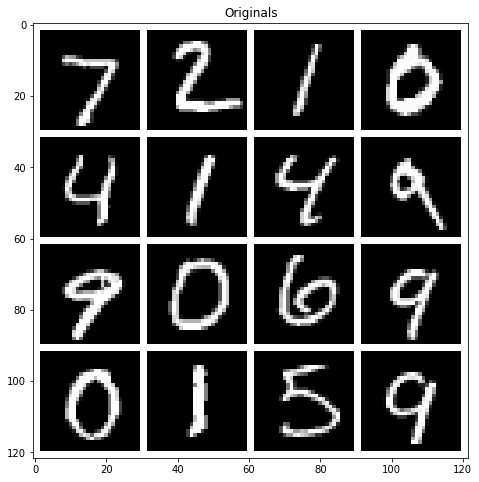

In [22]:
# Select N images that the model correctly classifies already
N = 16
adv_target = 8
x_imgs = []
x_labels = []
for x, label in test_ds:
    if label == adv_target:
        continue
    x = x.to(config.device).double()
    if (logits_to_label(model(x)) == label).item():
        # Make sure that the model correctly classifies this x
        x_imgs.append(x.cpu())
        x_labels.append(label)
    if len(x_imgs) >= N:
        break
x_labels = np.array(x_labels).reshape(4, 4)
grid = tv.utils.make_grid(x_imgs, nrow=4, pad_value=1)
plt.figure(figsize=(8, 8))
plt.title("Originals")
plt.imshow(np.transpose(grid, (1, 2, 0)))
print(x_labels)

In [23]:
xr_imgs = []
xr_labels = []
for x in tqdm.tqdm(x_imgs, ncols=80):
    xr = find_adversarial_example(model, x.numpy(), adv_target, config)
    xr_imgs.append(xr)
    new_label = logits_to_label(model(xr.to(config.device))).item()
    xr_labels.append(new_label)
xr_labels = np.array(xr_labels).reshape(4, 4)

100%|███████████████████████████████████████████| 16/16 [12:30<00:00, 46.92s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


New Labels:
[[8 8 8 8]
 [8 8 8 8]
 [8 8 8 8]
 [8 8 8 8]]


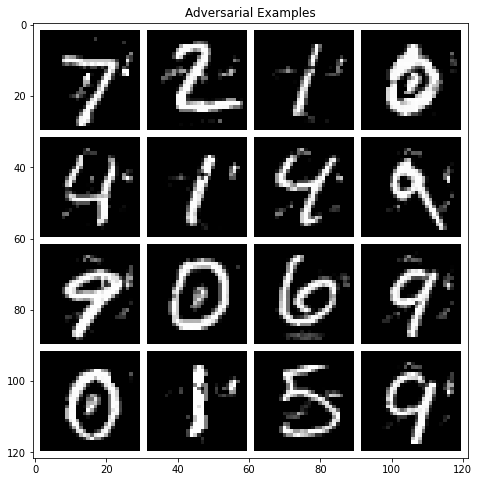

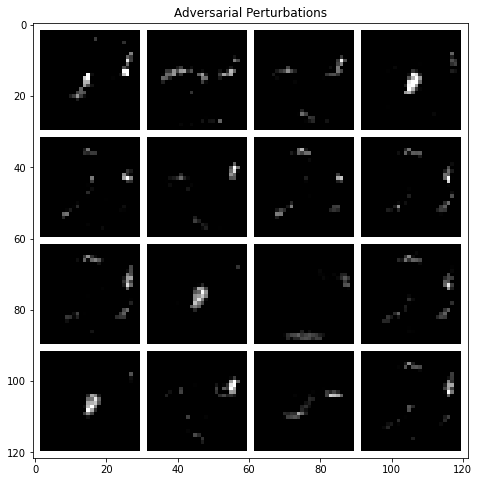

In [24]:
grid = tv.utils.make_grid(xr_imgs, nrow=4, pad_value=1)
plt.figure(figsize=(8, 8))
plt.title("Adversarial Examples")
plt.imshow(np.transpose(grid, (1, 2, 0)))
print(f"New Labels:\n{xr_labels}")

# Calculate r = (x + r) - x and display them
r_imgs = [xr - x for xr, x in zip(xr_imgs, x_imgs)]
grid = tv.utils.make_grid(r_imgs, nrow=4, pad_value=1)
plt.figure(figsize=(8, 8))
plt.title("Adversarial Perturbations")
plt.imshow(np.transpose(grid, (1, 2, 0)))

In [25]:
class FCNet200(nn.Module):
    def __init__(self, config):
        super(FCNet200, self).__init__()
        self.config = config
        self.model = nn.Sequential(
            nn.Linear(config.input_size, 200),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Linear(200, 200),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Linear(200, config.output_size),
        )
    
    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x).to(self.config.device)
        x = x.view(x.size(0), self.config.input_size)
        # Logits
        return self.model(x)

In [26]:
model2 = fetch_trained_model(
    FCNet200,
    train_dl,
    test_dl,
    True,
    "./data/model_2.pt",
    config
)

Test: 100%|██████████████████████████████████| 157/157 [00:00<00:00, 211.88it/s]

Test acc: 95.98%
FCNet200(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): LeakyReLU(negative_slope=0.1, inplace=True)
    (4): Linear(in_features=200, out_features=10, bias=True)
  )
)


In [27]:
cross_model_labels = []
for xr in xr_imgs:
    label = logits_to_label(model2(xr.unsqueeze(0).to(config.device))).item()
    cross_model_labels.append(label)
cross_model_labels = np.array(cross_model_labels).reshape(4, 4)
print(f"Cross Model Adverserial Predictions:\n{cross_model_labels}")
print(f"Attack Success: {(cross_model_labels == xr_labels).sum() / N:.2%}")

Cross Model Adverserial Predictions:
[[8 8 8 8]
 [4 8 8 8]
 [8 8 8 8]
 [8 8 8 9]]
Attack Success: 87.50%
